<font color='darkblue'>  
<h2> <center>Introduction To Word Embeddings</center>  <br>  <center> <i>How To Train Your Own Word Vectors Using The Simpsons Dialogues? </i> </center> 
</h2>
</font>


<font color='darkblue'> <h3> Why Word Vectors? </h3> </font>

As the volume of textual data generated on the web or uploaded in large servers around the world is growing in an exponential way, the need to analyze this type of data is becoming more and more crucial to understand trends, people behaviors, purchase intentions, and more generally the world we live in. 

In order to increase our ability to analyse relationships across words, sentences and documents, words can be transformed into vectors. In physics, vectors are arrows, in computer science and statistics, vectors are columns of values, like one numeric series in a dataframe. A word vector is literally a way for us to represent words as vectors, allowing us to use machine learning to better comprehend the structure and content of language by organizing concepts and learning the relationships among them.

In this tutorial, I am going to describe the different steps to follow to train a `word2vec` model with your own text-based dataset. Word2vec was created and published by Tomas Mikolov and his research team at Google in 2013. This tool provides an efficient implementation of the continuous bag-of-words (CBOW) and skip-gram architectures for computing vector representations of words -also called word embeddings-, using a two-layer neural network. It takes in observations (sentences, tweets, books), first constructs a vocabulary from the training text data, and then learns vector representation of words. The resulting word vector file can be used as features in many natural language processing and machine learning applications.


Here is a quick summary of the tutorial:

1. Import data and libraries
2. Pre-process text
3. Transform text into vectors with `word2vec` and train the model
4. Explore the model
5. Conclusion

<font color='darkblue'> <h4> My text dataset:</h4></font>

I could find on Kaggle this dataset containing script lines for approximately 600 Simpsons episodes, dating back to 1989. 
The `.csv` file is about 9MB, and includes more than 150K lines of dialogues between the different characters of the series, data is organized in 2 columns, each row showing the character's name and the text actually spoken, A-MA-ZING! 

File can be found here: https://www.kaggle.com/pierremegret/dialogue-lines-of-the-simpsons 

In [1]:
![Simpsons_magnifying.png](attachment:Simpsons_magnifying.png)

/bin/sh: 1: Syntax error: word unexpected (expecting ")")


<font color='darkblue'> <h3> 1. Import data and libraries </h3> </font>

In [1]:
# Install/upgrade Gensim if needed:
# !pip install gensim --upgrade

# Import Gensim and data science standard libraries:
import gensim # to get access to word2vec tool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Simpsons dataset, and read it in a pandas dataframe:
df = pd.read_csv('simpsons_dataset.csv')

In [2]:
# let's explore quickly the data:

# Data is showing as text strings, contains 2 columns and 158314 rows, and has some null values in each of the 2 columns:
print('Dataframe information: ')
print()
df.info()

Dataframe information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158314 entries, 0 to 158313
Data columns (total 2 columns):
raw_character_text    140500 non-null object
spoken_words          131855 non-null object
dtypes: object(2)
memory usage: 2.4+ MB


In [3]:
# Data looks great!
print('Dataframe top rows:')
df.head()

Dataframe top rows:


,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [4]:
# Here is the total of null values per columns:
print('Number of null values in dataframe: ')
df.isnull().sum()

Number of null values in dataframe: 


raw_character_text    17814
spoken_words          26459
dtype: int64

In [5]:
# Dataset is large enough to run our demo, so let's get rid of all null values:
df = df.dropna()

In [6]:
# Just making sure that our dataset is free of nulls now:
print('Number of null values remaining: ')
df.isnull().sum()

Number of null values remaining: 


raw_character_text    0
spoken_words          0
dtype: int64

In [7]:
# After dropping the nulls, 131853 rows remain in the dataset:
print('Dataframe shape:', df.shape)

Dataframe shape: (131853, 2)


In [8]:
# Let's rename the 2 columns: 
df.rename(columns={'raw_character_text': 'character', 'spoken_words': 'sequence'}, inplace=True)

<font color='darkblue'> <h3> 2. Pre-process text </h3> </font>

Pre-preprocessing is needed for transferring text from human language to machine-readable format for further processing. 

In [9]:
# Import text nltk pre-processing tools:
from nltk.stem import WordNetLemmatizer # to lemmatize words
from nltk.tokenize import RegexpTokenizer # to'tokenize' words
from nltk.corpus import stopwords # to remove stopwords.
import re # to access to regular expression matching operations

def preprocess (x): # create a pre-processing function:
    string_text = str(x) # convert text to strings
    lower_case = string_text.lower() # lowercase text
    lower_case = re.sub(r'[^a-zA-Z]', ' ', lower_case) # remove non-alphabetic characters
    retokenizer = RegexpTokenizer(r'\w+') 
    words = retokenizer.tokenize(lower_case) # split strings into substrings using a regular expression
    lemmer = WordNetLemmatizer() # take words and attempt to return their base/dictionary form.
    stops = set(stopwords.words('english')) # remove english stopwords, some example of stopwords are as 'what', 'as', 'of', 'into' 
    meaningful_words = [w for w in words if not w in stops]
    if len(meaningful_words) >2: # Let's remove sentences that are less than two words long as Word2Vec uses context words to learn the vector representation of a target word
        return " ".join([lemmer.lemmatize(word) for word in meaningful_words if not word in stops])

In [10]:
# Apply our function to the Simpsons dialogues:
df.sequence = df.sequence.apply(preprocess)

In [11]:
# Pre-processing is now done, but sentences that were 1 or 2 words long have been removed from our dataset, see 'sequence' at row [1]: 
print('Pre-processed dataframe top rows:')
df.head()

Pre-processed dataframe top rows:


,character,sequence
0,Miss Hoover,actually little sometimes disease magazine new...
1,Lisa Simpson,None
2,Miss Hoover,know although sure like talk touch lesson plan...
3,Lisa Simpson,life worth living
4,Edna Krabappel-Flanders,poll open end recess case decided put thought ...


In [12]:
# 38061 new nulls appear throughout our preprocessed dataset:
print('Number of null values in pre-processed dataframe: ', df.sequence.isnull().sum())

Number of null values in pre-processed dataframe:  38061


In [13]:
# ..so let's remove them as well as all duplicates:
df_clean = df.dropna().drop_duplicates()

In [14]:
# Our 'clean' dataset includes now 93317 rows of pre-processed text:
print('Shape of the clean version of our dataframe: ', df_clean.shape)

Shape of the clean version of our dataframe:  (93317, 2)


In [15]:
# Let's use Gensim Phrases package to automatically detect bigrams (common phrases) from a list of sentences. 
# This will connect "bart" and "simpson" when they appear side by side, so the model will treat 'homer_simpson' as one word 
from gensim.models.phrases import Phrases, Phraser # Phrases() takes a list of list of words as input:

sent = [row.split() for row in df_clean['sequence']] 
phrases = Phrases(sent, min_count=20) # we will ignore all bigrams with total collected count lower than 20.
bigram = Phraser(phrases)
sentences = bigram[sent]

print('First 15 bigrams in alpha order:' )
pd.DataFrame(sorted(bigram.phrasegrams)[:15], columns=['first_word', 'second_word'])

# We can see at row 12 that when 'bart' and 'simpson' show up side by side in a sentence, 
# they will be now considered as one word, the bigram 'bart_simpson' 

First 15 bigrams in alpha order:


,first_word,second_word
0,b'across',b'street'
1,b'always',b'wanted'
2,b'amusement',b'park'
3,b'angry',b'dad'
4,b'answer',b'question'
5,b'anyone',b'else'
6,b'ask',b'question'
7,b'aunt',b'selma'
8,b'aw',b'geez'
9,b'b',b'c'


In [16]:
from collections import defaultdict # defaultdict will allow us to count the number of occurrences for each word.

word_count = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_count[i] += 1

print("Number of words in our dataframe: ", len(word_count))

Number of words in our dataframe:  32943


In [17]:
# What are the most frequent words appearing in our data?
print('Most frequent words:')
pd.DataFrame(sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:15], columns=['word', 'frequency'])

# Homer and Bart are respectively the 10th and 12th most frequently used word in the show, 
# which makes sense as they are the 2 main characters of the series

Most frequent words:


,word,frequency
0,oh,6726
1,well,5425
2,like,4941
3,get,4924
4,one,4756
5,know,4593
6,hey,3754
7,right,3535
8,got,3420
9,homer,3040


<font color='darkblue'> <h3> 3. Transform text into vectors with `word2vec` and train the model </h3> </font>

After training, `word2vec` can be used to map each word to a vector of typically several hundred elements, which represent that word’s relation to other words. This vector is the neural network’s hidden layer.

In [18]:
from gensim.models import Word2Vec # import word2vec from Gensim library

w2v_model = Word2Vec(
                     size=300, # number of dimensions of our word vectors
                     window=10, # set the number of "context words" at 10
                     min_count=20, # ignore all words with total frequency lower than 20
                     sample=0.0001, # set the threshold for configuring which higher-frequency words are randomly downsampled
                     negative=20, # set the number of noise words to be drawn at 20
                     workers=4) # number of threads used in parallel to train the machine

In [19]:
# This step will build the vocabulary table:
w2v_model.build_vocab(sentences)

In [20]:
# Model can now be trained:
w2v_model.train(
    sentences,  
    total_examples=w2v_model.corpus_count, # number of sentences in the corpus
    epochs=30 # number of iterations in the corpus
)

(8742042, 18370410)

In [21]:
# init_sims will precompute L2-normalized vectors and ,if true, will forget the original vectors and only keep the normalized ones, this can save lots of memory
w2v_model.init_sims(replace=False)

<font color='darkblue'> <h3> 4. Explore the model </h3> </font>

Let's see what our model finds when we ask it to pull the top-10 most similar words to the main characters of the show with `most_similar` method:

In [22]:
print('Top 10 most similar words to Homer:')
pd.DataFrame(w2v_model.wv.most_similar(positive=["homer"]), columns=['word', 'frequency'])

Top 10 most similar words to Homer:


,word,frequency
0,marge,0.647157
1,becky,0.551345
2,lenny_carl,0.499023
3,creepy,0.498600
4,homie,0.497142
5,husband,0.485995
6,soul_mate,0.483098
7,crummy,0.481756
8,leave_alone,0.469040
9,sometime,0.468563


In [23]:
print('Top 10 most similar words to Bart:')
pd.DataFrame(w2v_model.wv.most_similar(positive=["bart"]), columns=['word', 'frequency'])

Top 10 most similar words to Bart:


,word,frequency
0,lisa,0.745548
1,maggie,0.613382
2,learned_lesson,0.602921
3,mom_dad,0.602509
4,pay_attention,0.596564
5,mom,0.589715
6,homework,0.586715
7,tell_truth,0.582463
8,feel_better,0.581206
9,dr_hibbert,0.581166


In [24]:
print('Top 10 most similar words to Lisa:')
pd.DataFrame(w2v_model.wv.most_similar(positive=["lisa"]), columns=['word', 'frequency'])

Top 10 most similar words to Lisa:


,word,frequency
0,bart,0.745548
1,learned_lesson,0.603608
2,homework,0.603168
3,maggie,0.574106
4,mom,0.568127
5,grownup,0.563802
6,saxophone,0.561525
7,surprised,0.559258
8,daughter,0.558765
9,math,0.550277


In [25]:
print('Top 10 most similar words to Marge:')
pd.DataFrame(w2v_model.wv.most_similar(positive=["marge"]), columns=['word', 'frequency'])

Top 10 most similar words to Marge:


,word,frequency
0,homer,0.647157
1,husband,0.601620
2,homie,0.543166
3,becky,0.541192
4,marriage,0.536475
5,ashamed,0.531238
6,tell_truth,0.512526
7,disappointed,0.511782
8,fault,0.506138
9,brunch,0.499643


It looks like all this information makes sense! We can use `doesnt_match` method to find which word from the given list doesn’t go with the others:

In [26]:
print('Word to exclude from the list:', w2v_model.wv.doesnt_match(['bart', 'lisa', 'maggie', 'milhouse']))

Word to exclude from the list: milhouse


C:\Users\Administrator\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [27]:
print('Word to exclude from the list:', w2v_model.wv.doesnt_match(['moe', 'lenny', 'carl', 'homer', 'marge']))

Word to exclude from the list: marge


In physics, we can add/subtract vectors to understand how two forces might act on an object. Let's see if we can use `most_similar` method to do the same thing with word vectors.

What happens when adding 'woman' to 'homer' and substract 'man?

In [28]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["man"], topn=10)

[('marge', 0.5261433124542236),
 ('husband', 0.4614260196685791),
 ('homie', 0.449959933757782),
 ('brunch', 0.4463199973106384),
 ('wife', 0.44602805376052856),
 ('marriage', 0.44539350271224976),
 ('grownup', 0.44457897543907166),
 ('wasted', 0.4415558874607086),
 ('affair', 0.4279390275478363),
 ('luann', 0.4259093403816223)]

This is correct, Marge is Homer female counterpart!

<font color='darkblue'> <h3> 5. Conclusion </h3> </font>

In this quick introduction to word embeddings I tried to describe as simply as possible the different steps you will need to go through if you want to train a word vectorizer with your own data. In this example, I chose to use Google's `word2vec` method, but other vectorizers can be available on sklearn's library as `CountVectorizer` , `HashingVectorizer` or `TfidfVectorizer`. Word embedding provides to machines much more information about words than has previously been possible using traditional representations of words. Word vectors are essential for solving NLP problems such as speech recognition, sentiment analysis, named entity recognition, spam filtering, and machine translation, they are an amazingly powerful concept and applications in this field are practically infinite. The importance of word embeddings in deep learning becomes more and more evident by looking at the number of researches in the field, so I hope that this tutorial was useful for you and helped you to better understand the mechanisms of these methods.

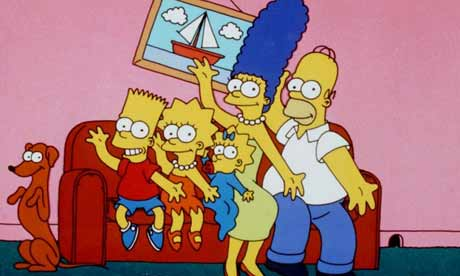